### Istanbul Travel Guide

In [37]:
import os
from dotenv import load_dotenv, dotenv_values

# Load the .env file
load_dotenv()

True

### create an index for the documents

In [6]:
### create an index for the documents

from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PyPDFLoader

file_paths = ["C://Users//LENOVO//Desktop//LangGraph//datasets//istanbul-city-guide.pdf",
              "C://Users//LENOVO//Desktop//LangGraph//datasets//istanbul-visitors-guide-2.pdf",
              "C://Users//LENOVO//Desktop//LangGraph//datasets//istanbul-visitors-guide.pdf"]

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

docs = []

for file_path in file_paths:
    loader = PyPDFLoader(file_path)
    docs.extend(loader.load())

text_splitter = RecursiveCharacterTextSplitter(chunk_size=512,
                                               chunk_overlap=64,
                                               add_start_index=True)

all_splits = text_splitter.split_documents(docs)

vectorstore = Chroma.from_documents(documents=all_splits,
                                    collection_name="guide-rag-chroma",
                                    embedding=embeddings
                                   )

retriever = vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": 3})

In [8]:
retriever.invoke("Hagia Sophia")

[Document(metadata={'page': 14, 'source': 'C://Users//LENOVO//Desktop//LangGraph//datasets//istanbul-visitoers-guide.pdf', 'start_index': 0}, page_content='13\nHISTORY\nTHe ONe aND ONl Y HagIa SOPHIa \nThe Hagia Sophia, one of the \nhistorical architectural wonders \nof the world, has a very important place in the art world with its architecture, grandness, size and functionality. The Hagia Sophia, the biggest church constructed by the East Roman Empire in Istanbul, \nhas been constructed three times \nin the same location. The church \nwas the place in which rulers \nwere crowned, and it was also the biggest operational cathedral in \nthe city throughout the Byzantine'),
 Document(metadata={'page': 37, 'source': 'C://Users//LENOVO//Desktop//LangGraph//datasets//istanbul-visitoers-guide-2.pdf', 'start_index': 879}, page_content='acter.  Mosque elements such as a mimbar, a mihrab, preacher’s platform and wooden balustrades \nwere added inside. Mahmut I had a library built here. The sout

### TranslateQuery

In [9]:
### TranslateQuery

from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate

# LLM
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# Prompt
system = """Translate the question into English if the question is in another language. \n
If the question is in English, do nothing."""
translate_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Translate the question into English.",
        ),
    ]
)

turkish_question = "Ayasofya cami nerededir?"
english_question2 = "What is the best traditional food to eat in Istanbul?"

question_translater = translate_prompt | llm | StrOutputParser()
print(question_translater.invoke({"question": turkish_question}))
print(question_translater.invoke({"question": english_question2}))

Where is the Hagia Sophia mosque?
What is the best traditional food to eat in Istanbul?


### router

In [10]:
### Router

from typing import Literal

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI


# Data model
class RouteQuery(BaseModel):
    """
    Route a user query to the most relevant datasource.
    """

    datasource: Literal["vectorstore", "web_search"] = Field(
        ...,
        description="Given a user question choose to route it to web search or a vectorstore.",
    )


# LLM with function call
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
structured_llm_router = llm.with_structured_output(RouteQuery)

# Prompt
system = """
You are an expert at routing a user question to a vectorstore or web search.
Vectorstore contains documents about the history of Istanbul, touristic and historical places of Istanbul, and food and travel tips for tourists.
Use vectorstore for questions on these topics. If the question is about transportation, weather, and other things, use web search.
"""

route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

question_router = route_prompt | structured_llm_router

print(
    question_router.invoke(
        {"question": "What is the weather like in Istanbul?"}
    )
)

print(
    question_router.invoke(
        {"question": "Where is the Hagia Sophia located?"}
        )
)

datasource='web_search'
datasource='vectorstore'


### Retrieval Grader

In [11]:
### Retrieval Grader

# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        ...,
        description="Documents are relevant to the question, 'yes' or 'no'"
    )


# LLM with function call
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeDocuments)

# Prompt
system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader

question = "Where is the Hagia Sophia located?"

docs_relevant = retriever.invoke(question)
doc_txt = docs_relevant[1].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

question_2 = "What are LeBron James' stats for 2023-2024 NBA Regular season?"

docs_relevant_2 = retriever.invoke(question)
doc_txt_2 = docs_relevant[1].page_content
print(retrieval_grader.invoke({"question": question_2, "document": doc_txt_2}))

binary_score='yes'
binary_score='no'


### Generate

In [12]:
### Generate

from langchain import hub
from langchain_core.output_parsers import StrOutputParser

# Prompt
prompt = hub.pull("e-ticaret-qa-prompt/istanbul-guide-rag")

# LLM
llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0)


# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
generation = rag_chain.invoke({"context": docs_relevant, "question": question})
print(generation)

The Hagia Sophia is located in Sultanahmet Square, which is in the heart of Istanbul, Turkey. This iconic structure is one of the most significant historical and architectural wonders of the world. Originally built as a cathedral during the Byzantine Empire, it has served various purposes throughout its history, including being a mosque and, more recently, a museum. The Hagia Sophia is renowned for its stunning architecture and grand scale, making it a must-visit attraction for tourists from around the globe.


### Hallucination Grader

In [13]:
### Hallucination Grader

# Data model
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )


# LLM with function call
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeHallucinations)

# Prompt
system = """You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. \n 
     Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts."""
hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
    ]
)

hallucination_grader = hallucination_prompt | structured_llm_grader
hallucination_grader.invoke({"documents": docs, "generation": generation})

GradeHallucinations(binary_score='yes')

### Answer Grader

In [14]:
### Answer Grader

# Data model
class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score: str = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )


# LLM with function call
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeAnswer)

# Prompt
system = """You are a grader assessing whether an answer addresses / resolves a question \n 
     Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question."""
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)

answer_grader = answer_prompt | structured_llm_grader
answer_grader.invoke({"question": question, "generation": generation})

GradeAnswer(binary_score='yes')

### Question Re-writer

In [15]:
### Question Re-writer

# LLM
llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)

# Prompt
system = """You a question re-writer that converts an input question to a better version that is optimized \n 
     for vectorstore retrieval. Look at the input and try to reason about the underlying semantic intent / meaning."""
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()
question_rewriter.invoke({"question": question})

'What is the location of the Hagia Sophia?'

### tavily web search tool

In [16]:
### tavily web search

from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=3)

In [17]:
web_search_tool.invoke("What is the weather like in Istanbul?")

[{'url': 'https://www.weatherapi.com/',
  'content': "{'location': {'name': 'Istanbul', 'region': 'Istanbul', 'country': 'Turkey', 'lat': 41.02, 'lon': 28.96, 'tz_id': 'Europe/Istanbul', 'localtime_epoch': 1724317089, 'localtime': '2024-08-22 11:58'}, 'current': {'last_updated_epoch': 1724316300, 'last_updated': '2024-08-22 11:45', 'temp_c': 27.2, 'temp_f': 81.0, 'is_day': 1, 'condition': {'text': 'Sunny', 'icon': '//cdn.weatherapi.com/weather/64x64/day/113.png', 'code': 1000}, 'wind_mph': 9.4, 'wind_kph': 15.1, 'wind_degree': 240, 'wind_dir': 'WSW', 'pressure_mb': 1008.0, 'pressure_in': 29.77, 'precip_mm': 0.0, 'precip_in': 0.0, 'humidity': 74, 'cloud': 0, 'feelslike_c': 27.9, 'feelslike_f': 82.3, 'windchill_c': 28.9, 'windchill_f': 84.0, 'heatindex_c': 30.1, 'heatindex_f': 86.1, 'dewpoint_c': 17.9, 'dewpoint_f': 64.3, 'vis_km': 10.0, 'vis_miles': 6.0, 'uv': 7.0, 'gust_mph': 13.9, 'gust_kph': 22.3}}"},
 {'url': 'https://www.weathertab.com/en/c/e/08/republic-of-turkey/istanbul/istanbul

### GraphState

In [18]:
from typing import List

from typing_extensions import TypedDict


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """

    question: str
    generation: str
    documents: List[str]

In [19]:
from langchain.schema import Document

def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}

def translator(state):
    """
    Translate the question into English if needed.

    Args:
        state(dict): The current graph state

    Returns:
        state (dict): The question translated to English language.
    """
    print("---TRANSLATE THE QUERY TO ENGLISH---")
    question = state["question"]

    # Translate
    translated_question = question_translater.invoke(question)
    return {"question": translated_question}


def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    return {"documents": filtered_docs, "question": question}


def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}


def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---WEB SEARCH---")
    question = state["question"]

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)

    return {"documents": web_results, "question": question}


### Edges ###


def route_question(state):
    """
    Route question to web search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]
    source = question_router.invoke({"question": question})
    if source.datasource == "web_search":
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "web_search"
    elif source.datasource == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    filtered_documents = state["documents"]

    if not filtered_documents:
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"


def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    grade = score.binary_score

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score.binary_score
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
    else:
        pprint("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"

### Build Graph

In [21]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("translate_query", translator)  # translator
workflow.add_node("web_search", web_search)  # web search
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generate
workflow.add_node("transform_query", transform_query)  # transform_query

# Build graph
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "web_search": "web_search",
        "vectorstore": "translate_query",  # Check if query needs translation
    },
)
workflow.add_edge("translate_query", "retrieve")  # Translate query before retrieving
workflow.add_edge("web_search", "generate")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "retrieve")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "transform_query",
    },
)

# Compile
app = workflow.compile()

### visualize the agent flow

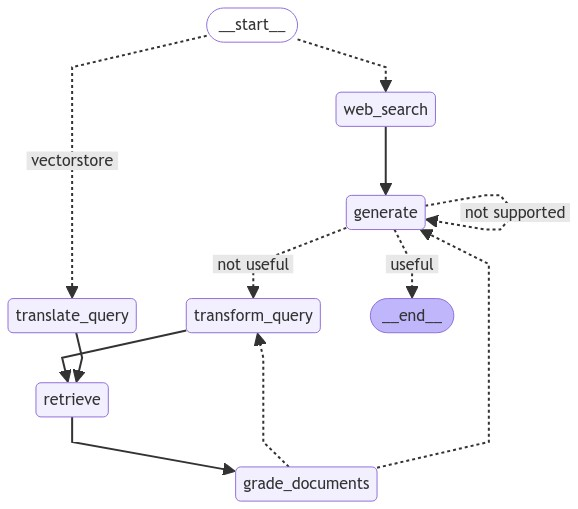

In [22]:
#Draw the graph

from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [36]:
app.invoke({"question":"쉴레이마니예 모스크의 역사에 대한 정보를 제공하세요."})["generation"]

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
---TRANSLATE THE QUERY TO ENGLISH---
---RETRIEVE---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---


"The Suleymaniye Mosque is one of the most significant landmarks in Istanbul, both architecturally and historically. It was commissioned by Sultan Suleyman the Magnificent, one of the most illustrious rulers of the Ottoman Empire, and was completed in 1557. The mosque was designed by the renowned Ottoman chief architect Mimar Sinan, who is celebrated for his contributions to Ottoman architecture and is often regarded as one of the greatest architects in history.\n\nThe mosque is situated on one of the highest hills in Istanbul, allowing it to dominate the city's skyline. It was built as a grand statement of the Ottoman Empire's power and sophistication, serving as an Islamic counterpart to the Byzantine Hagia Sophia, which had been a symbol of Christian architecture for centuries.\n\nThe architectural design of the Suleymaniye Mosque is particularly noteworthy for its vast central dome, which is surrounded by tiered domes, creating a harmonious and majestic interior space. Sinan's inno

In [27]:
response["generation"]

'As of 2024, the estimated population of Istanbul is approximately 16,047,350 according to the latest projections from the UN World Urbanization Prospects. This reflects a growth of about 199,582 people from the previous year, indicating a 1.26% annual increase. The Turkish Statistical Institute also provides a slightly different figure, estimating the population at around 15,815,231. Regardless of the source, it is clear that Istanbul continues to be a rapidly growing metropolis, with significant population growth observed over the decades.'

## run the agents to get response

### use web-search tool

In [29]:
import time
from pprint import pprint

# Run
inputs = {
    "question": "What is the weather like in Istanbul now?"
    }

start = time.time()
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])
end = time.time()

print(f"Estimated response time: {end-start} seconds.")

---ROUTE QUESTION---
---ROUTE QUESTION TO WEB SEARCH---
---WEB SEARCH---
"Node 'web_search':"
'\n---\n'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
"Node 'generate':"
'\n---\n'
('As of now, the weather in Istanbul is quite pleasant. The current '
 'temperature is approximately 28.2°C (82.8°F), and it is sunny, making it a '
 'great day to explore the city. The humidity level is around 70%, which can '
 'make it feel a bit warmer, with a "feels like" temperature of 28.3°C '
 '(83.0°F). \n'
 '\n'
 'There is a moderate breeze coming from the west-southwest at about 11.9 mph '
 '(19.1 kph), which can provide some relief from the heat. The atmospheric '
 'pressure is 1008 mb, and there are no precipitation forecasts, so you can '
 'expect a dry day. Visibility is good at 10 km (6 miles), and the UV index is '
 "relatively high at 8.0, so it's advisable to wear s

### use vectorstore to answer the question

In [31]:
import time
from pprint import pprint

# Run
inputs = {
    "question": "Who was built the Hagia Sophia?"
    }

start = time.time()
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])
end = time.time()

print(f"Estimated response time: {end-start} seconds.")

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
---TRANSLATE THE QUERY TO ENGLISH---
"Node 'translate_query':"
'\n---\n'
---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---
"Node 'grade_documents':"
'\n---\n'
---TRANSFORM QUERY---
"Node 'transform_query':"
'\n---\n'
---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---
"Node 'grade_documents':"
'\n---\n'
---TRANSFORM QUERY---
"Node 'transform_query':"
'\n---\n'
---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRAD

In [32]:
import time
from pprint import pprint

# Run
inputs = {
    "question": "İstanbul'da gezmek için 3 tane tarihi mekan önerebilir misin? Bu mekanlardan çok kısaca bahset?"
    }

start = time.time()
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])
end = time.time()

print(f"Estimated response time: {end-start} seconds.")

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
---TRANSLATE THE QUERY TO ENGLISH---
"Node 'translate_query':"
'\n---\n'
---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
"Node 'grade_documents':"
'\n---\n'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
"Node 'generate':"
'\n---\n'
('Certainly! Here are three historical places to visit in Istanbul that are '
 'rich in history and culture:\n'
 '\n'
 '1. **Hagia Sophia (Ayasofya)**: Originally constructed as a Christian '
 "basilica in 537 AD, Hagia Sophia is one of Istanbul's most iconic landmarks. "
 'It features a vast interior adorned with stunning mosaics and a magnificent '
 'dome that was an architectural marvel of its tim

In [33]:
import time
from pprint import pprint

# Run
inputs = {
    "question": "Какие текущие цены на общественный транспорт в Стамбул?"
    }

start = time.time()
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])
end = time.time()

print(f"Estimated response time: {end-start} seconds.")

---ROUTE QUESTION---
---ROUTE QUESTION TO WEB SEARCH---
---WEB SEARCH---
"Node 'web_search':"
'\n---\n'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
"Node 'generate':"
'\n---\n'
('С 29 июля 2024 года в Стамбуле действуют новые тарифы на общественный '
 'транспорт. Вот актуальные цены на разовые электронные билеты:\n'
 '\n'
 '- 1 поездка — ₺30\n'
 '- 2 поездки — ₺50\n'
 '- 3 поездки — ₺80\n'
 '- 4 поездки — ₺100\n'
 '- 5 поездок — ₺120\n'
 '\n'
 'Также стоит отметить, что стоимость проезда с использованием карты '
 'Истанбулкарт значительно дешевле. В 2022 году цена самой карты составляла 10 '
 'TL, и при покупке необходимо было положить на карту не менее четырех лир. '
 'Цена за одну поездку с Истанбулкарт на 50% ниже, чем при покупке разового '
 'билета.\n'
 '\n'
 'Общественный транспорт в Стамбуле включает в себя автобусы, трамваи, '
 'маршрутки-долмуши, м

In [35]:
import time
from pprint import pprint

# Run
inputs = {
    "question": "쉴레이마니예 모스크의 역사에 대한 정보를 제공하세요."
    }

start = time.time()
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])
end = time.time()

print(f"Estimated response time: {end-start} seconds.")

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
---TRANSLATE THE QUERY TO ENGLISH---
"Node 'translate_query':"
'\n---\n'
---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
"Node 'grade_documents':"
'\n---\n'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
"Node 'generate':"
'\n---\n'
('The Suleymaniye Mosque is one of the most significant landmarks in Istanbul, '
 'both architecturally and historically. It was commissioned by Sultan '
 'Suleyman the Magnificent, one of the most renowned sultans of the Ottoman '
 'Empire, and was completed in 1557. The mosque was designed by the celebrated '
 'Ottoman architect Mimar Sinan, who is often regarded as the greatest '
 'architect o